In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from sparse_conv2d import SparseConv2d
from utils import *

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

Using /home/jl/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/jl/.cache/torch_extensions/py312_cu121/sparse_conv2d_csrc/build.ninja...
/data/Projets/IA/experimentations/venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module sparse_conv2d_csrc...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module sparse_conv2d_csrc...


ninja: no work to do.
cuda
Thu Aug  8 22:29:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   62C    P5             18W /   80W |      41MiB /   6144MiB |     22%      Default |
|                                         |                        |                  N/A |
+--------------------

Train size :  60000
validation size :  10000
torch.Size([128, 1, 28, 28])
torch.Size([128])


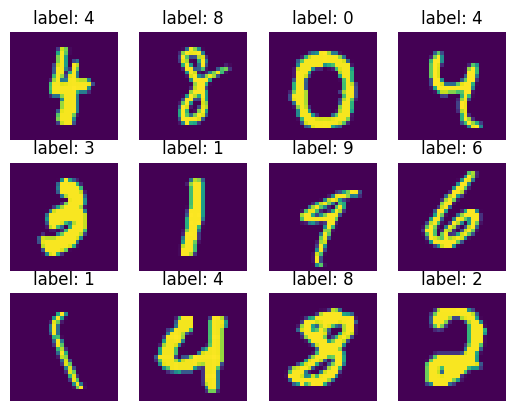

In [2]:
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

train_set = torchvision.datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=train_transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=6)

validation_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

validation_set = torchvision.datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=validation_transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=True, num_workers=6)

print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)
print(labels.shape)

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [25]:
class Conv2dModel(nn.Module):
    def __init__(self):
        super(Conv2dModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 16, 3, 1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64)
        x = self.fc1(x)
        return x
    
model = Conv2dModel().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

26266


Epoch: 1/100   Train loss: 0.4518   Valid loss: 0.1234   Train acc: 0.8649   Valid acc: 0.9613   Elapsed time: 5.9294 sec   Time left: 587.0072 sec
Epoch: 2/100   Train loss: 0.1129   Valid loss: 0.0720   Train acc: 0.9663   Valid acc: 0.9783   Elapsed time: 11.5276 sec   Time left: 548.6131 sec
Epoch: 3/100   Train loss: 0.0784   Valid loss: 0.0641   Train acc: 0.9758   Valid acc: 0.9790   Elapsed time: 16.6430 sec   Time left: 496.1833 sec
Epoch: 4/100   Train loss: 0.0622   Valid loss: 0.0451   Train acc: 0.9808   Valid acc: 0.9856   Elapsed time: 22.1477 sec   Time left: 528.4365 sec
Epoch: 5/100   Train loss: 0.0522   Valid loss: 0.0456   Train acc: 0.9839   Valid acc: 0.9855   Elapsed time: 27.6067 sec   Time left: 518.5884 sec
Epoch: 6/100   Train loss: 0.0457   Valid loss: 0.0428   Train acc: 0.9856   Valid acc: 0.9851   Elapsed time: 34.3960 sec   Time left: 638.1819 sec
Epoch: 7/100   Train loss: 0.0395   Valid loss: 0.0440   Train acc: 0.9879   Valid acc: 0.9851   Elapsed ti

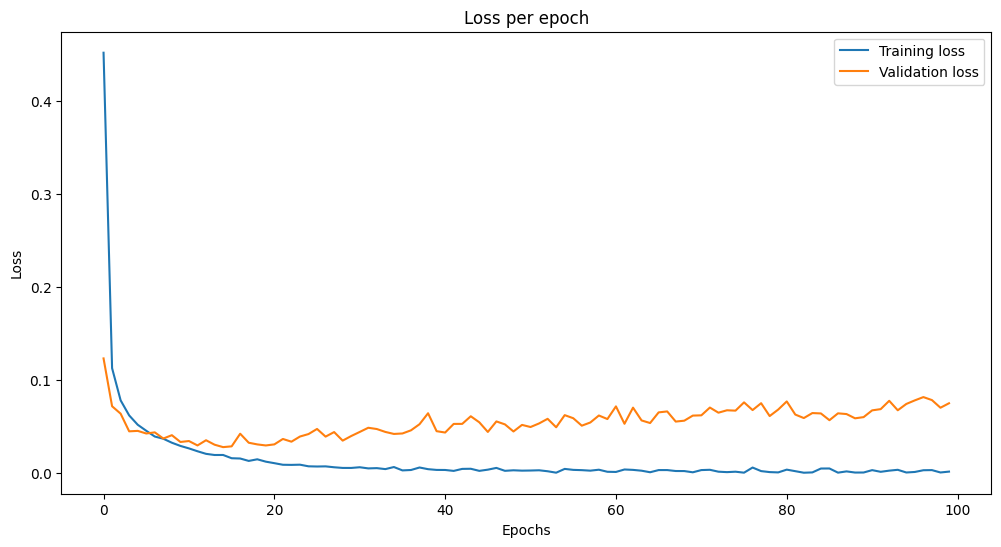

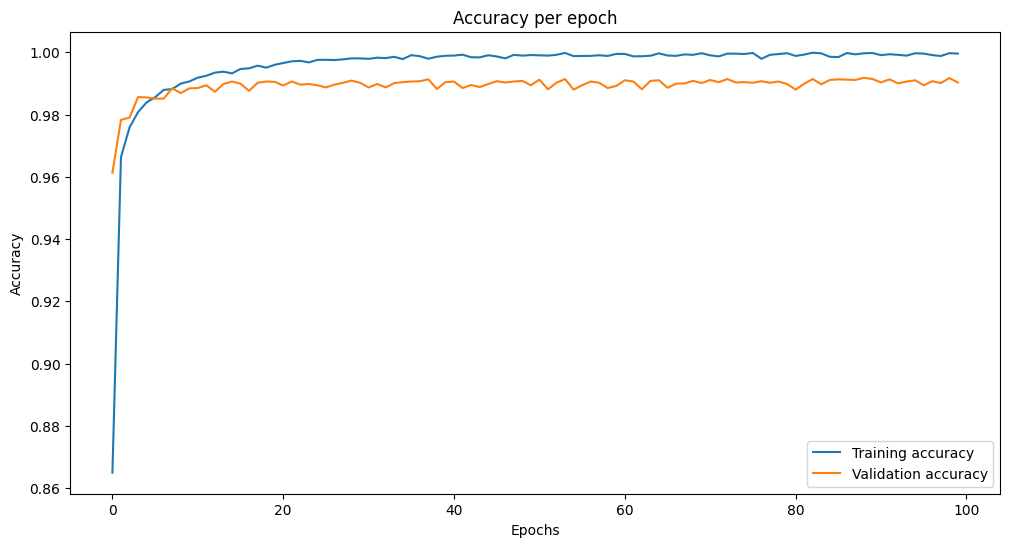

Accuracy of basic linear 2d model:  0.9903


In [26]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    100
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear 2d model: ", test_accuracy(model, validationLoader, validation_set, device))

In [21]:
class SparseConv2dModel(nn.Module):
    def __init__(self):
        super(SparseConv2dModel, self).__init__()
        self.conv1 = SparseConv2d(1, 16, 3, 1, 0, True)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = SparseConv2d(16, 16, 3, 8, 0, True)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = SparseConv2d(16, 32, 3, 8, 0, True)
        self.conv4 = SparseConv2d(32, 64, 3, 8, 0, True)
        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64)
        x = self.fc1(x)
        return x
    
model = SparseConv2dModel().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

8858


Epoch: 1/100   Train loss: 0.5941   Valid loss: 0.1869   Train acc: 0.8202   Valid acc: 0.9425   Elapsed time: 9.0753 sec   Time left: 898.4584 sec
Epoch: 2/100   Train loss: 0.1600   Valid loss: 0.1244   Train acc: 0.9515   Valid acc: 0.9640   Elapsed time: 18.1515 sec   Time left: 889.4456 sec
Epoch: 3/100   Train loss: 0.1124   Valid loss: 0.0897   Train acc: 0.9647   Valid acc: 0.9719   Elapsed time: 27.5099 sec   Time left: 907.7528 sec
Epoch: 4/100   Train loss: 0.0932   Valid loss: 0.0685   Train acc: 0.9714   Valid acc: 0.9793   Elapsed time: 37.3026 sec   Time left: 940.0865 sec
Epoch: 5/100   Train loss: 0.0795   Valid loss: 0.0641   Train acc: 0.9756   Valid acc: 0.9792   Elapsed time: 46.9719 sec   Time left: 918.5773 sec
Epoch: 6/100   Train loss: 0.0699   Valid loss: 0.0570   Train acc: 0.9786   Valid acc: 0.9824   Elapsed time: 56.4920 sec   Time left: 894.8740 sec
Epoch: 7/100   Train loss: 0.0632   Valid loss: 0.0547   Train acc: 0.9804   Valid acc: 0.9829   Elapsed ti

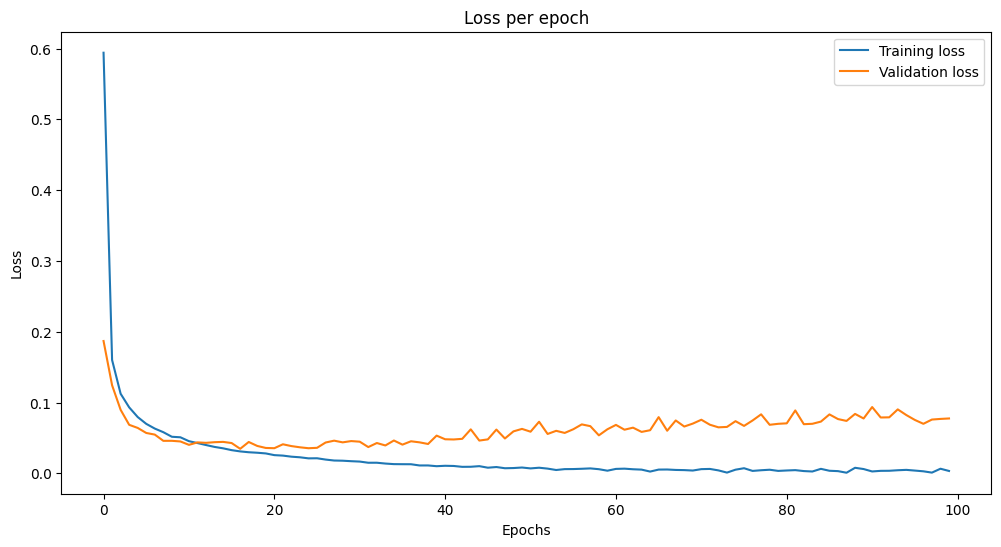

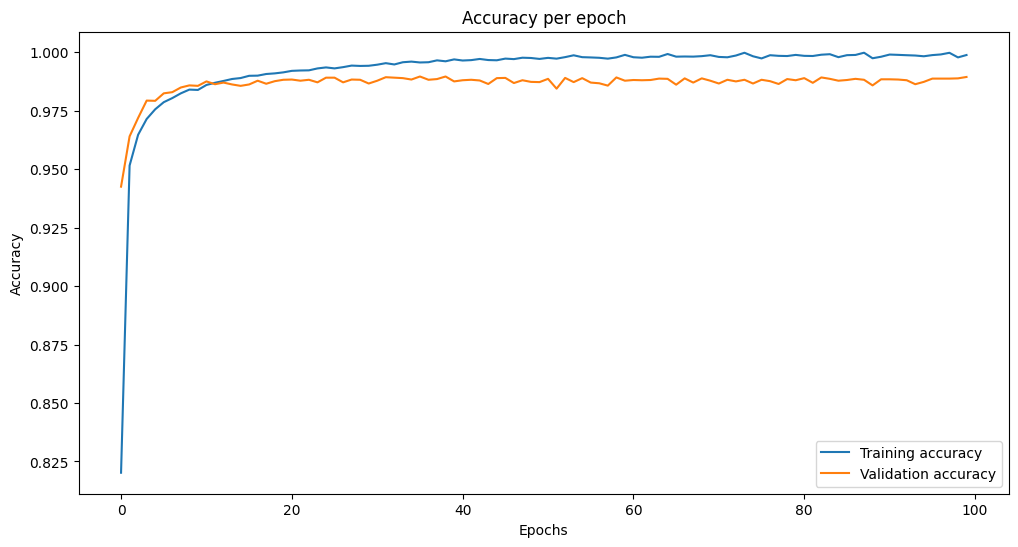

Accuracy of basic linear 2d model:  0.9894


In [22]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    100
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear 2d model: ", test_accuracy(model, validationLoader, validation_set, device))

Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
validation size :  10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6562586..1.8754958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6200646..1.0388715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6947775..1.6972679].


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51387656..1.0590489].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7308184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3473134..1.7600527].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6818826..1.8762391].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6672956..1.6267456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44221467..1.7755606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.709

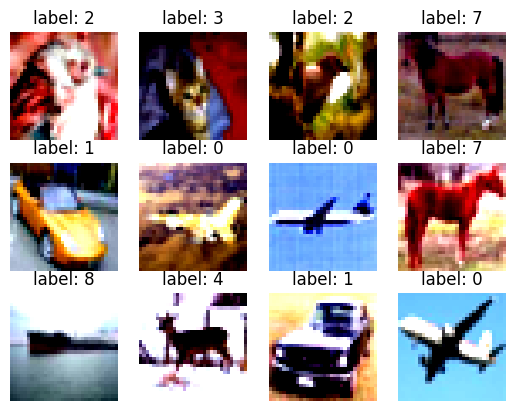

In [2]:
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

train_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=train_transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=6)

validation_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

validation_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=validation_transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=True, num_workers=6)

print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)
print(labels.shape)

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [15]:
class Conv2dModel(nn.Module):
    def __init__(self):
        super(Conv2dModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 3, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*2*2, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64*2*2)
        x = self.fc1(x)
        return x
    
model = Conv2dModel().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

28474


Epoch: 1/100   Train loss: 1.7149   Valid loss: 1.4995   Train acc: 0.3723   Valid acc: 0.4543   Elapsed time: 12.5231 sec   Time left: 1239.7863 sec
Epoch: 2/100   Train loss: 1.4004   Valid loss: 1.3379   Train acc: 0.4964   Valid acc: 0.5247   Elapsed time: 24.9099 sec   Time left: 1213.8928 sec
Epoch: 3/100   Train loss: 1.2825   Valid loss: 1.3180   Train acc: 0.5435   Valid acc: 0.5200   Elapsed time: 38.0191 sec   Time left: 1271.5817 sec
Epoch: 4/100   Train loss: 1.2159   Valid loss: 1.2116   Train acc: 0.5686   Valid acc: 0.5736   Elapsed time: 51.2553 sec   Time left: 1270.6652 sec
Epoch: 5/100   Train loss: 1.1540   Valid loss: 1.1175   Train acc: 0.5943   Valid acc: 0.6035   Elapsed time: 64.7299 sec   Time left: 1280.0819 sec
Epoch: 6/100   Train loss: 1.1040   Valid loss: 1.1159   Train acc: 0.6150   Valid acc: 0.6053   Elapsed time: 77.8406 sec   Time left: 1232.3969 sec
Epoch: 7/100   Train loss: 1.0600   Valid loss: 1.0901   Train acc: 0.6292   Valid acc: 0.6136   Ela

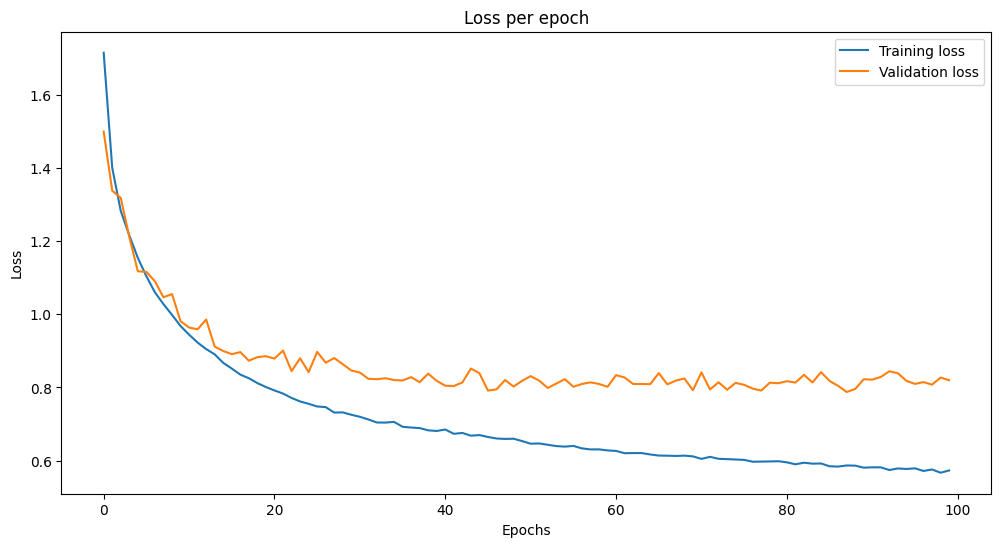

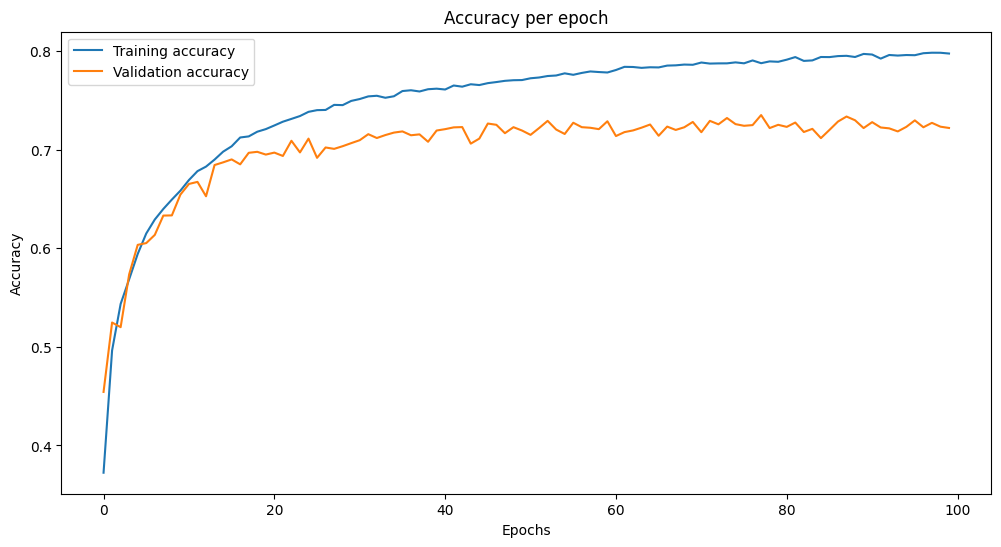

Accuracy of basic linear model:  0.7221


In [16]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    100
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear model: ", test_accuracy(model, validationLoader, validation_set, device))

In [8]:
class SparseConv2dModel(nn.Module):
    def __init__(self):
        super(SparseConv2dModel, self).__init__()
        self.conv1 = SparseConv2d(3, 16, 3, 3, 0, True)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = SparseConv2d(16, 16, 3, 8, 0, True)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = SparseConv2d(16, 32, 3, 8, 0, True)
        self.conv4 = SparseConv2d(32, 64, 3, 8, 0, True)
        self.fc1 = nn.Linear(64*2*2, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64*2*2)
        x = self.fc1(x)
        return x
    
model = SparseConv2dModel().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

11066


Epoch: 1/100   Train loss: 1.8061   Valid loss: 1.6220   Train acc: 0.3452   Valid acc: 0.4194   Elapsed time: 16.8022 sec   Time left: 1663.4157 sec
Epoch: 2/100   Train loss: 1.5288   Valid loss: 1.4668   Train acc: 0.4523   Valid acc: 0.4782   Elapsed time: 33.4969 sec   Time left: 1636.0748 sec
Epoch: 3/100   Train loss: 1.4034   Valid loss: 1.3471   Train acc: 0.5060   Valid acc: 0.5341   Elapsed time: 50.4278 sec   Time left: 1642.2900 sec
Epoch: 4/100   Train loss: 1.3321   Valid loss: 1.2939   Train acc: 0.5339   Valid acc: 0.5512   Elapsed time: 66.7893 sec   Time left: 1570.6883 sec
Epoch: 5/100   Train loss: 1.2706   Valid loss: 1.2661   Train acc: 0.5576   Valid acc: 0.5560   Elapsed time: 84.2251 sec   Time left: 1656.3859 sec
Epoch: 6/100   Train loss: 1.2245   Valid loss: 1.2277   Train acc: 0.5742   Valid acc: 0.5671   Elapsed time: 102.2913 sec   Time left: 1698.2101 sec
Epoch: 7/100   Train loss: 1.1922   Valid loss: 1.1833   Train acc: 0.5866   Valid acc: 0.5883   El

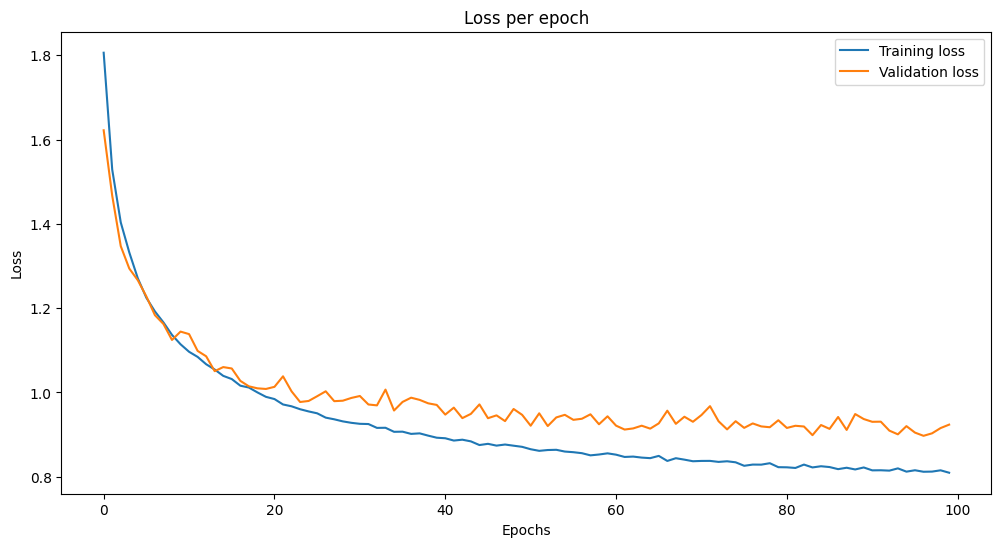

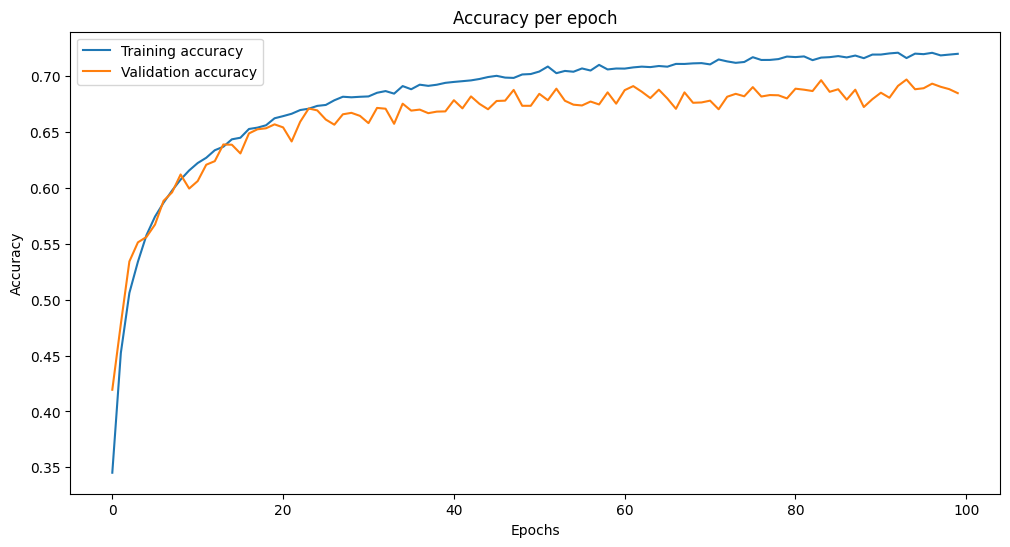

Accuracy of basic linear model:  0.6846


In [19]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    100
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear model: ", test_accuracy(model, validationLoader, validation_set, device))

In [5]:
class SparsePositionalConv2dModel(nn.Module):
    def __init__(self):
        super(SparsePositionalConv2dModel, self).__init__()
        self.conv1 = SparseConv2d(3, 16, 3, 3, 0, True)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = SparseConv2d(16, 16, 3, 8, 0.5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = SparseConv2d(16, 32, 3, 8, 0.5)
        self.conv4 = SparseConv2d(32, 64, 3, 8, 0.5)
        self.fc1 = nn.Linear(64*2*2, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 64*2*2)
        x = self.fc1(x)
        return x
    
model = SparsePositionalConv2dModel().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

11066


Epoch: 1/100   Train loss: 1.8022   Valid loss: 1.6171   Train acc: 0.3429   Valid acc: 0.4230   Elapsed time: 17.0507 sec   Time left: 1688.0193 sec
Epoch: 2/100   Train loss: 1.5335   Valid loss: 1.4584   Train acc: 0.4477   Valid acc: 0.4829   Elapsed time: 34.6304 sec   Time left: 1722.7956 sec
Epoch: 3/100   Train loss: 1.4237   Valid loss: 1.3990   Train acc: 0.4965   Valid acc: 0.5062   Elapsed time: 52.3451 sec   Time left: 1718.3164 sec
Epoch: 4/100   Train loss: 1.3519   Valid loss: 1.3053   Train acc: 0.5247   Valid acc: 0.5491   Elapsed time: 70.0500 sec   Time left: 1699.6580 sec
Epoch: 5/100   Train loss: 1.2978   Valid loss: 1.3087   Train acc: 0.5458   Valid acc: 0.5394   Elapsed time: 87.7188 sec   Time left: 1678.5236 sec
Epoch: 6/100   Train loss: 1.2521   Valid loss: 1.2370   Train acc: 0.5632   Valid acc: 0.5707   Elapsed time: 105.3246 sec   Time left: 1654.9249 sec
Epoch: 7/100   Train loss: 1.2177   Valid loss: 1.2334   Train acc: 0.5756   Valid acc: 0.5738   El

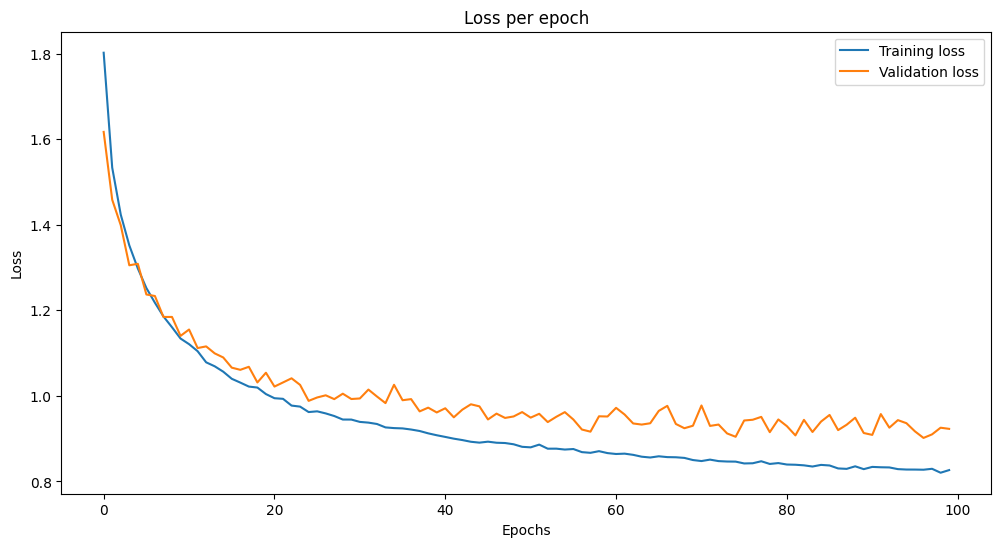

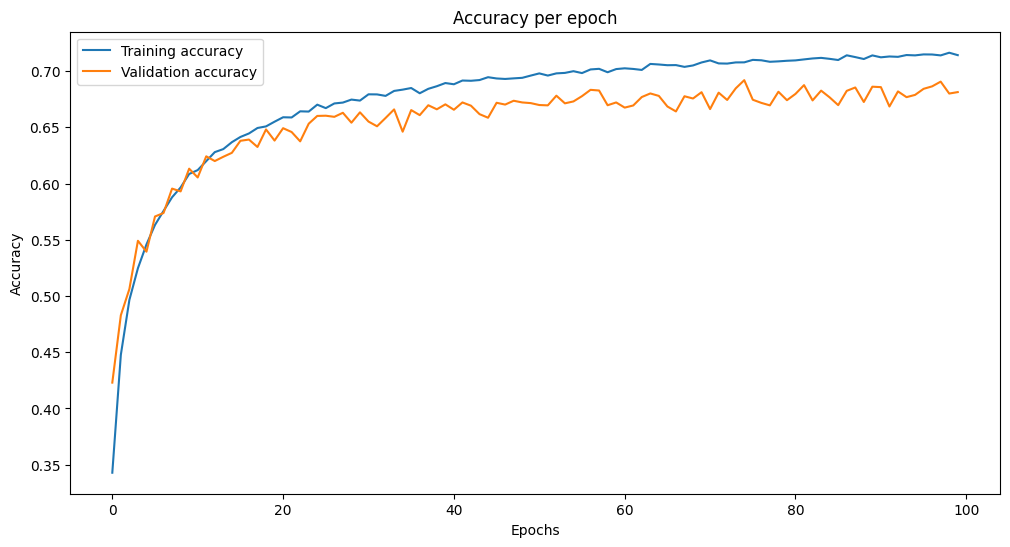

Accuracy of basic linear 2d model:  0.6813


In [6]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    100
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear 2d model: ", test_accuracy(model, validationLoader, validation_set, device))